# Сегментация клиентов в Python 

## RFM-анализ

In [6]:
import pandas as pd
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [7]:
orders = pd.read_csv('rfm_data.csv',sep=',')

In [9]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_date   5009 non-null   datetime64[ns]
 1   order_id     5009 non-null   object        
 2   customer     5009 non-null   object        
 3   grand_total  5009 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.7+ KB


In [11]:
orders.order_date = pd.to_datetime(orders.order_date)

In [24]:
orders.order_id = orders.order_id.astype('str')
orders.customer = orders.customer.apply(str)

In [30]:
orders.order_date.describe(datetime_is_numeric = True)

count                             5009
mean     2013-05-08 11:24:12.505490176
min                2011-01-04 00:00:00
25%                2012-05-31 00:00:00
50%                2013-07-11 00:00:00
75%                2014-05-20 00:00:00
max                2014-12-31 00:00:00
Name: order_date, dtype: object

In [33]:
last_date = orders.order_date.max()

In [34]:
last_date

Timestamp('2014-12-31 00:00:00')

In [52]:

rfmTable = orders.groupby('customer')\
    .agg({'order_date': lambda x: (last_date - x.max())\
      .days, # Recency #Количество дней с последнего заказа
            'order_id': lambda x: len(x),      # Frequency #Количество заказов
            'grand_total': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)


## Проверка на уникальность

In [54]:
print(rfmTable.shape[0])
print(orders.customer.nunique())

793
793


## Таблица квантилей

In [68]:
quantiles = rfmTable.quantile(q = [0.25, 0.5, 0.75])

In [56]:
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [57]:
rfmSegmentation = rfmTable

## Сегментация по классам

In [58]:


def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [65]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency']\
                                .apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency']\
                                .apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value']\
                                .apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)\
                            + rfmSegmentation.F_Quartile.map(str)\
                            + rfmSegmentation.M_Quartile.map(str)

In [66]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


## Визуализации по кол-ву сегментов

In [64]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)


F_Quartile,1,2,3,4
R_Quartile,,,,
1,58,65,24,56
2,45,56,27,66
3,39,58,30,73
4,17,19,26,134


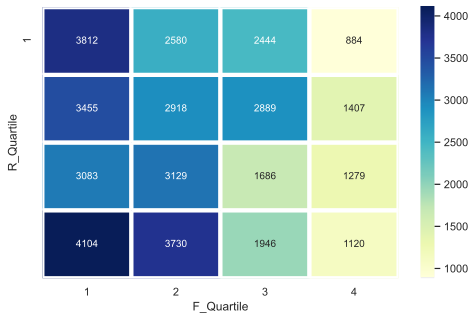

In [61]:

rfm_table = rfmSegmentation.pivot_table(
                        index = 'R_Quartile', 
                        columns = 'F_Quartile', 
                        values = 'monetary_value', 
                        aggfunc = np.median).applymap(int)
sns.heatmap(rfm_table,
            cmap = "YlGnBu",
            annot = True,
            fmt = ".0f",
            linewidths = 4.15,
            annot_kws = {"size": 10},
            yticklabels = 4);